In [2]:
from utils import get_dataframe
from nltk.tokenize import word_tokenize, sent_tokenize

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

In [3]:
df = get_dataframe()
df

,question,human_answers,chatgpt_answers
0,Historical P/E ratios of small-cap vs. large-c...,[There is most likely an error in the WSJ's da...,[Historical price-to-earnings (P/E) ratios for...
1,Should you co-sign a personal loan for a frien...,[I know this question has a lot of answers alr...,[Co-signing a personal loan for a friend or fa...
2,Should I avoid credit card use to improve our ...,[If you pay it off before the cycle closes it ...,[It can be a good idea to avoid using credit c...
3,Difference between 'split and redemption' of s...,[It is the first time I encounter redemption p...,[Share split and redemption are two different ...
4,Pros & cons of investing in gold vs. platinum?,[Why Investors Buy Platinum is an old (1995) a...,[Gold and platinum are both precious metals th...
...,...,...,...
837,"Please explain what is ""Punched cards""",[A punched card (also punch card or punched-ca...,[Punched cards were a means of storing and pro...
838,"Please explain what is ""Paper tape""",[Punched tape or perforated paper tape is a fo...,[Paper tape is a medium for storing and transm...
839,"Please explain what is ""BBC Model B""",[The British Broadcasting Corporation Microcom...,[The BBC Model B is a computer that was made b...
840,"Please explain what is ""O level""",[The O-Level (Ordinary Level) is a subject-bas...,"[""O level"" refers to the General Certificate o..."


In [4]:
df["len_human_answer"] = df.human_answers.apply(lambda x : len(x))

In [5]:
df["len_human_answer"][df["len_human_answer"] > 1]

Series([], Name: len_human_answer, dtype: int64)

In [6]:
df["len_ai_answer"] = df.chatgpt_answers.apply(lambda x : len(x))

In [7]:
df[df["len_ai_answer"] == 3].chatgpt_answers[0]

['Sound mass is a term used to describe a type of texture in music that is characterized by a dense, homogenous sound created by the layering and combining of multiple voices or instruments. There are many composers who have used sound mass techniques in their compositions, including:\\n\\nPierre Boulez: Boulez was a French composer and conductor who was known for his use of sound mass techniques in his compositions. He often used these techniques to create a sense of density and complexity in his music.\\n\\nGyörgy Ligeti: Ligeti was a Hungarian-Austrian composer who was known for his use of sound mass techniques in his music. His compositions often featured complex, layered textures that were created by the layering and combining of multiple voices or instruments.\\n\\nKarlheinz Stockhausen: Stockhausen was a German composer who was known for his innovative use of sound mass techniques in his music. He often used these techniques to create a sense of density and complexity in his com

In [8]:
df.columns

Index(['question', 'human_answers', 'chatgpt_answers', 'len_human_answer',
       'len_ai_answer'],
      dtype='object')

In [9]:
df.human_answers = df.human_answers.apply(lambda x : x[0])

In [10]:
df

,question,human_answers,chatgpt_answers,len_human_answer,len_ai_answer
0,Historical P/E ratios of small-cap vs. large-c...,There is most likely an error in the WSJ's dat...,[Historical price-to-earnings (P/E) ratios for...,1,1
1,Should you co-sign a personal loan for a frien...,I know this question has a lot of answers alre...,[Co-signing a personal loan for a friend or fa...,1,1
2,Should I avoid credit card use to improve our ...,If you pay it off before the cycle closes it w...,[It can be a good idea to avoid using credit c...,1,1
3,Difference between 'split and redemption' of s...,It is the first time I encounter redemption pr...,[Share split and redemption are two different ...,1,1
4,Pros & cons of investing in gold vs. platinum?,Why Investors Buy Platinum is an old (1995) ar...,[Gold and platinum are both precious metals th...,1,1
...,...,...,...,...,...
837,"Please explain what is ""Punched cards""",A punched card (also punch card or punched-car...,[Punched cards were a means of storing and pro...,1,1
838,"Please explain what is ""Paper tape""",Punched tape or perforated paper tape is a for...,[Paper tape is a medium for storing and transm...,1,1
839,"Please explain what is ""BBC Model B""",The British Broadcasting Corporation Microcomp...,[The BBC Model B is a computer that was made b...,1,1
840,"Please explain what is ""O level""",The O-Level (Ordinary Level) is a subject-base...,"[""O level"" refers to the General Certificate o...",1,1


In [11]:
df.chatgpt_answers = df.chatgpt_answers.apply(lambda x : x[0])

In [12]:
df

,question,human_answers,chatgpt_answers,len_human_answer,len_ai_answer
0,Historical P/E ratios of small-cap vs. large-c...,There is most likely an error in the WSJ's dat...,Historical price-to-earnings (P/E) ratios for ...,1,1
1,Should you co-sign a personal loan for a frien...,I know this question has a lot of answers alre...,Co-signing a personal loan for a friend or fam...,1,1
2,Should I avoid credit card use to improve our ...,If you pay it off before the cycle closes it w...,It can be a good idea to avoid using credit ca...,1,1
3,Difference between 'split and redemption' of s...,It is the first time I encounter redemption pr...,Share split and redemption are two different c...,1,1
4,Pros & cons of investing in gold vs. platinum?,Why Investors Buy Platinum is an old (1995) ar...,Gold and platinum are both precious metals tha...,1,1
...,...,...,...,...,...
837,"Please explain what is ""Punched cards""",A punched card (also punch card or punched-car...,Punched cards were a means of storing and proc...,1,1
838,"Please explain what is ""Paper tape""",Punched tape or perforated paper tape is a for...,Paper tape is a medium for storing and transmi...,1,1
839,"Please explain what is ""BBC Model B""",The British Broadcasting Corporation Microcomp...,The BBC Model B is a computer that was made by...,1,1
840,"Please explain what is ""O level""",The O-Level (Ordinary Level) is a subject-base...,"""O level"" refers to the General Certificate of...",1,1


In [13]:
df = df.drop(columns=['len_human_answer', 'len_ai_answer'])

In [14]:
df.iloc[1000]


question               Should I pay off investment property mortgage
human_answers      I would not recommend using your own money to ...
chatgpt_answers    There are a few factors to consider when decid...
Name: 1000, dtype: object

In [15]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def char_tokenize(doc):
    return [char for char in doc]

def byte_tokenize(doc):
    tokens = doc.encode("utf-8")
    tokens = list(map(int, tokens))
    return [str(token) for token in tokens]

def gpt_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

In [16]:
df_1 = df.copy(deep=True)
df_2 = df.copy(deep=True)

In [17]:
df_1["target"] = 1
df_1 = df_1.drop(columns=['human_answers'])
df_1.rename(columns={"chatgpt_answers": "answers"}, inplace=True)

df_2["target"] = 0
df_2 = df_2.drop(columns=['chatgpt_answers'])
df_2.rename(columns={"human_answers": "answers"}, inplace=True)

In [18]:
df_model = pd.concat([df_1, df_2])
df_model

,question,answers,target
0,Historical P/E ratios of small-cap vs. large-c...,Historical price-to-earnings (P/E) ratios for ...,1
1,Should you co-sign a personal loan for a frien...,Co-signing a personal loan for a friend or fam...,1
2,Should I avoid credit card use to improve our ...,It can be a good idea to avoid using credit ca...,1
3,Difference between 'split and redemption' of s...,Share split and redemption are two different c...,1
4,Pros & cons of investing in gold vs. platinum?,Gold and platinum are both precious metals tha...,1
...,...,...,...
837,"Please explain what is ""Punched cards""",A punched card (also punch card or punched-car...,0
838,"Please explain what is ""Paper tape""",Punched tape or perforated paper tape is a for...,0
839,"Please explain what is ""BBC Model B""",The British Broadcasting Corporation Microcomp...,0
840,"Please explain what is ""O level""",The O-Level (Ordinary Level) is a subject-base...,0


In [19]:
# shuffling

df_model = df_model.sample(frac=1).reset_index(drop=True)
df_model

,question,answers,target
0,"Please explain what is ""Paraconsistent logic""",Paraconsistent logic is a type of logical syst...,1
1,how are antibodies used in,"An antibody (Ab), also known as an immunoglobu...",0
2,Hourly rate negotiation tips for paid internship,Here are some tips for negotiating your hourly...,1
3,where is al jazeera based,"Al Jazeera ( ' , literally ""The Island"", abbre...",0
4,What Is Range in Math,is a function from domain X to codomain Y.,0
...,...,...,...
14415,S&P reports: number of shareholders?,Yes these are the number of shareholders that ...,0
14416,What are the easier to qualify home loans in C...,There are a few types of home loans in Canada ...,1
14417,What effect would sovereign default of a Europ...,"A sovereign default, which is the failure of a...",1
14418,what are the uses for gui,"GUIs can be used in computers , hand-held devi...",0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_model["answers"], df_model["target"], test_size=0.2, random_state=69)

 X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)

 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [21]:
model = make_pipeline(CountVectorizer(tokenizer=gpt_tokenize, lowercase=True), LogisticRegression(random_state=69, penalty = 'l2'))

In [22]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))

/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Features dimension: (11536, 28894)
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1441
           1       0.99      0.98      0.98      1443

    accuracy                           0.98      2884
   macro avg       0.98      0.98      0.98      2884
weighted avg       0.98      0.98      0.98      2884



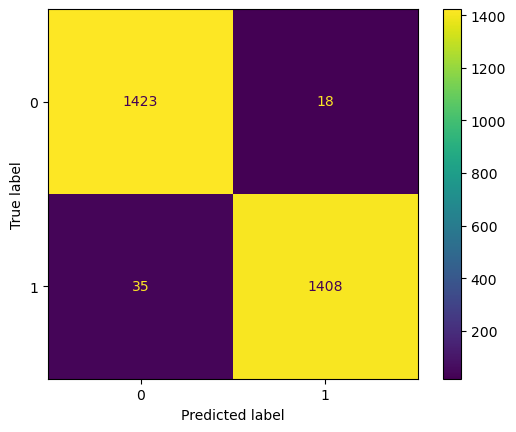

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

In [25]:
model.predict(["Hello I am stupid"])

array([0])